In [192]:
%config InlineBackend.figure_format = 'png'

# load pm data
from datetime import datetime
import poly_api
import poly_datasets


market_ids = [
    "0xc2c1038424a37a044781d1915e82ddbea1515d79cdb8966a2bf0a658b178b21c",
    "0x69c7ea583787dee4228468864414f33c84c3ab58c2eaba37ca7a5c0aed4e899e",
    "0xd7fa09afd9c184f94edb6f15f5f98640dc3f5418ffbd520a10ef3f4775414c73",
    "0x78dd44195111f89210b059180792a1fa156d1f211392e76575dc36846e815987",
    "0x7c662197ecf9c6c2441c1cb57e8c8a761a5782eeb0c219dc14daf3f165d188a1",
    "0x0f3131c874579825ecdbbda8c7aeed071aa908d7c993792c393285900e68906f",
    "0x44c5b4d851e8c06698c13b54e8ba33e37637e13bdb3f375ce0b6727b2aa06b48",
    "0x0bdabf234110590a6475e88f386ec7512f0f0d8038989e39259f0eb995650594",
    "0xcdab757d22e9ca242163475ed1426e6a8d2c9a579b39198f7cec223024ee2e89",
    "0x8d29692749f246da11fb329a2ecaf95d08cc6c97d3f8ebe0c052d1ce42057595",
    "0xda728da52dda8a465dd49a1e9a6daa000b2116bd799b18ec383c68e68c693bda",
    "0x263c7f77dc9cc2a68ce238794051b4801ae0d0aa0b1242a54726a8860a1809e8",
    "0xd100eaa5eb47d06b9f3f4ff37ad34c1e588b3f322cd8d7d408c379a2ce3ea03e",
    "0x906a2b90f30c62e09dce56fababafafbc4338cb8dac94ac6c3038327d0447180",
]

ts_options = poly_api.TSOptions(
    fidelity_in_minutes=3,
    interval_to_load=(
        datetime.fromisoformat("2025-01-02 19:00"),  # Market start date
        datetime.fromisoformat("2025-01-30 23:00"),  # Market end date
    ),
)
raw_markets = poly_api.load_markets_data(market_ids, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


In [193]:
# load binance data
import binance_datasets


binance_df = binance_datasets.load_matching_binance_data(
    processed_markets, ts_options.fidelity_in_minutes, "BTCUSDT"
)
binance_deltas = [binance_df.loc[market.index, "delta"] for market in processed_markets]

Loading from binance at intervals: from 2025-01-02 19:09:00 until 2025-01-30 21:57:00


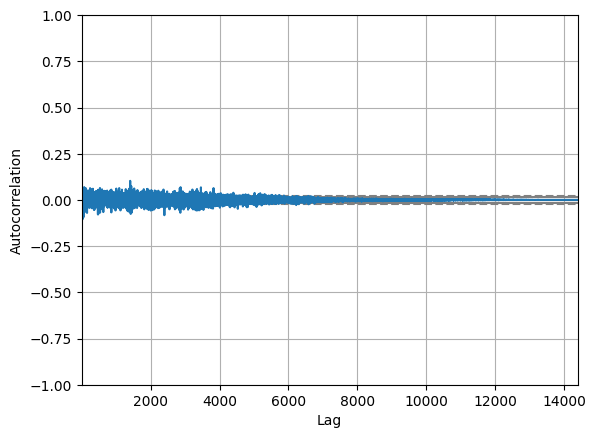

In [ ]:
# See if BTC deltas are correlated
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

# Calculate autocorrelation using numpy
autocorr = np.correlate(binance_deltas[0], binance_deltas[0], mode="full")

# Plot autocorrelation
pd.plotting.autocorrelation_plot(autocorr)
plt.show()

In [26]:
autocorr[0:10]

array([  1809.5712,   -836.5953,   4435.7503, -20326.4722,   1380.8795,
        29902.7275,  30050.5829, -47782.727 , -35021.715 ,  13449.5613])

In [ ]:
def trading_func_use_all(
    idx: int,
    shares: np.ndarray,
    binance_delta: np.ndarray,
    traded: np.ndarray,
    poly_close_price: np.ndarray,
    balance: np.ndarray,
    min_delta: float,
    transaction_fee: float,
):
    btc_price_grew = binance_delta[idx] > min_delta
    holding_shares = shares[idx - 1] > 0

    if not holding_shares:
        if btc_price_grew:
            # Buy shares
            spend = balance[idx - 1]
            spend_on_shares = spend - transaction_fee
            shares[idx] = spend_on_shares / poly_close_price[idx]
            balance[idx] = balance[idx - 1] - spend
            traded[idx] = True

    elif holding_shares:
        # Sell shares
        aquired_balance = shares[idx - 1] * poly_close_price[idx]
        balance[idx] = balance[idx - 1] + aquired_balance - transaction_fee
        shares[idx] = 0
        traded[idx] = True

    # If a new balance was not set, keep the previous one
    if not traded[idx]:
        balance[idx] = balance[idx - 1]
        shares[idx] = shares[idx - 1]


def trading_func_use_capped(
    idx: int,
    shares: np.ndarray,
    binance_delta: np.ndarray,
    traded: np.ndarray,
    poly_close_price: np.ndarray,
    balance: np.ndarray,
    min_delta: float,
    transaction_fee: float,
    purchase_cap: float = 100,
):
    btc_price_grew = binance_delta[idx] > min_delta
    holding_shares = shares[idx - 1] > 0

    if not holding_shares:
        if btc_price_grew:
            # Buy shares
            spend = min(purchase_cap + transaction_fee, balance[idx - 1])
            spend_on_shares = spend - transaction_fee
            shares[idx] = spend_on_shares / poly_close_price[idx]
            balance[idx] = balance[idx - 1] - spend
            traded[idx] = True

    elif holding_shares:
        # Sell shares
        balance[idx] = (
            balance[idx - 1]
            + (shares[idx - 1] * poly_close_price[idx])
            - transaction_fee
        )
        shares[idx] = 0
        traded[idx] = True

    # If a new balance was not set, keep the previous one
    if not traded[idx]:
        balance[idx] = balance[idx - 1]
        shares[idx] = shares[idx - 1]


def simulate_trading(
    poly_close_price: np.ndarray,
    binance_delta: pd.Series,
    starting_balance=100,
    min_delta=30,
    transaction_fee=0.0,
):
    # Add an extra item at the beginning to simplify indexing
    poly_price = np.concat((np.array([poly_close_price[0]]), poly_close_price))
    binance_delta = np.concat(([0], binance_delta.to_numpy()))

    # TODO: My trades can influence the market. Add some cap to the amount of shares I can buy/sell?
    # TODO: Not all my shares can get bought. Account for that too.
    # TODO: Does it make sense to look at consecutive change of BTC price?
    #       Datapoints where BTC grew 2+ consecutive intervals at a time?
    balance = np.zeros(len(poly_price)) * np.nan
    shares = np.zeros(len(poly_price)) * np.nan
    traded = np.zeros(len(poly_price))

    balance[0] = starting_balance
    shares[0] = 0

    idx = 1
    while idx < (len(poly_price) - 1):
        trading_func_use_all(
            idx,
            shares,
            binance_delta,
            traded,
            poly_price,
            balance,
            min_delta,
            transaction_fee,
        )
        idx += 1

    # Set the last balance and shares to some value (NaN by default)
    balance[idx] = balance[idx - 1]

    # If has shares at the end, sell them all
    if shares[idx] > 0:
        aquired_balance = shares[idx] * poly_price[idx - 1]
        balance[idx] = balance[idx - 1] + aquired_balance - transaction_fee
        shares[idx] = 0
        traded[idx] = True
    else:
        shares[idx] = shares[idx - 1]

    actives = balance + (shares * poly_price)
    actives_end = actives[1:]
    actives_start = actives[:-1]
    actives_delta = actives_end - actives_start
    actives_delta_percentage = actives_delta / actives_start

    trades_made = np.sum(traded)
    total_fees = transaction_fee * trades_made
    return {
        "actives_start": actives[0],
        "actives_end": round(float(actives[idx]), 4),
        "actives": actives,
        "actives_delta": actives_delta,
        "actives_delta_percentage": actives_delta_percentage,
        "actives_won_lost": (
            round(float(sum(actives_delta[actives_delta > 0])), 4),
            round(float(sum(actives_delta[actives_delta < 0])), 4),
        ),
        "trades_made": trades_made,
        "trades_won_lost": (
            int(sum(actives_delta > 0)),
            int(sum(actives_delta < 0)),
        ),
        "trade_fees": round(total_fees, 4),
        "trade_descisions_made": len(poly_price),
    }


def print_result(result: dict):
    for key, value in result.items():
        if not isinstance(value, np.ndarray):
            print(f"{key}: {value}")

In [368]:
def symmetric_ylim(x):
    max_val = max(abs(x))
    return -max_val * 1.1, max_val * 1.1


def plot_result(result: dict):
    actives: np.ndarray = result["actives"]
    actives_delta = result["actives_delta"]
    actives_delta_percentage = result["actives_delta_percentage"]

    print_result(result)

    fig, axs = plt.subplots(3, 1, figsize=(6, 11))

    axs[0].plot(actives)
    axs[0].set_title("Actives")
    axs[0].set_xlabel("Trade Index")

    axs[1].plot(actives_delta)
    axs[1].set_title("Actives Delta")
    axs[1].set_xlabel("Trade Index")
    axs[1].set_ylim(symmetric_ylim(actives_delta))

    axs[2].plot(actives_delta_percentage)
    axs[2].set_title("Actives Delta in Percentage")
    axs[2].set_xlabel("Trade Index")
    axs[2].set_ylim(symmetric_ylim(actives_delta_percentage))

    plt.tight_layout()
    plt.show()

will-bitcoin-reach-120000-by-january-31-2025
actives_start: 100.0
actives_end: 117479.5734
actives_won_lost: (961413.8977, -844034.3243)
trades_made: 8318.0
trades_won_lost: (473, 7845)
trade_fees: 21.6268
trade_descisions_made: 13494


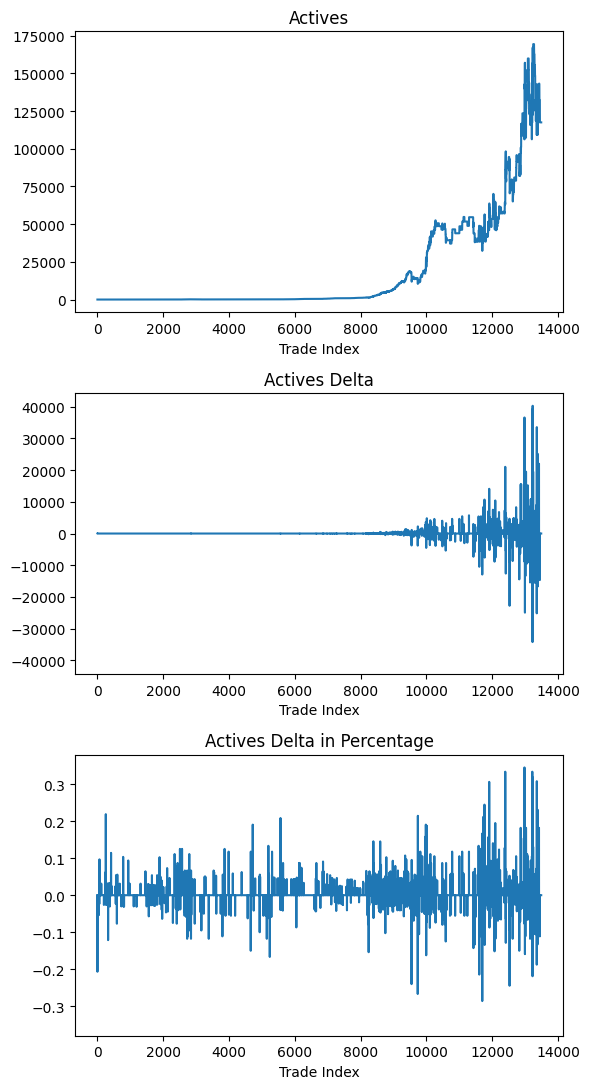

In [446]:
market_data = processed_markets[4]
binance_delta = binance_deltas[4]

print(market_data.label)
result = simulate_trading(
    market_data.close,
    binance_delta,
    starting_balance=100,
    min_delta=10,
    transaction_fee=0.0026,
)
plot_result(result)

In [425]:
np.round(result["actives_delta"][0:100], 2)

array([ 0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  , -7.29, -0.  ,
       -0.  ,  0.  , -0.  , -1.18,  0.  , -0.  , -7.13,  0.  ,  0.  ,
       -0.  , -2.41, -0.  , -2.41,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,
       -0.  , -4.26,  0.  ,  0.  , -0.  , -0.  , -0.  , -0.  ,  0.  ,
        0.  ,  0.  , -0.  , -1.79,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,
        7.11, -0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,
        0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  ,
       -0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  , -0.  ,
       -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,
        0.  ])

In [417]:
np.round((result["actives_delta"][1:][0:10]) * (result["actives_delta"][:-1][0:10]), 2)

array([-0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.  ,  0.02,  0.02,  0.  ,
       -0.  ])

In [415]:
tmp = np.round(result["actives_delta"][1:] * result["actives_delta"][:-1], 4)
tmp[0:100]

array([-0.    ,  0.    , -0.    ,  0.    ,  0.    , -0.    ,  0.019 ,
        0.019 ,  0.    , -0.    , -0.    ,  0.0031, -0.    , -0.    ,
        0.0185, -0.    ,  0.    , -0.    ,  0.0063,  0.0063,  0.0063,
       -0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
       -0.    ,  0.    , -0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.    ,
        0.    , -0.    , -0.    ,  0.0111, -0.    ,  0.    , -0.    ,
        0.    ,  0.    ,  0.    , -0.    ,  0.    ,  0.    , -0.    ,
        0.0047, -0.    ,  0.    ,  0.    ,  0.    , -0.    , -0.0185,
       -0.0185,  0.    , -0.    ,  0.    ,  0.    , -0.    ,  0.    ,
       -0.    ,  0.    ,  0.    , -0.    ,  0.    , -0.    ,  0.    ,
       -0.    ,  0.    ,  0.    ,  0.    , -0.    ,  0.    , -0.    ,
        0.    , -0.    ,  0.    , -0.    ,  0.    ,  0.    ,  0.    ,
       -0.    ,  0.    ,  0.    ,  0.    , -0.    ,  0.    , -0.    ,
        0.    ,  0. 

Label: will-bitcoin-reach-120000-by-january-31-2025
actives_start: 100.0
actives_end: 1167.8952
actives_percentage_won_lost: (5.961, -3.3638)
actives_won_lost: (2627.9917, -1560.0964)
trades_made: 14012
trades_won_lost: (445, 6561)
trade_fees: 36.4312
trade_descisions_made: 13494


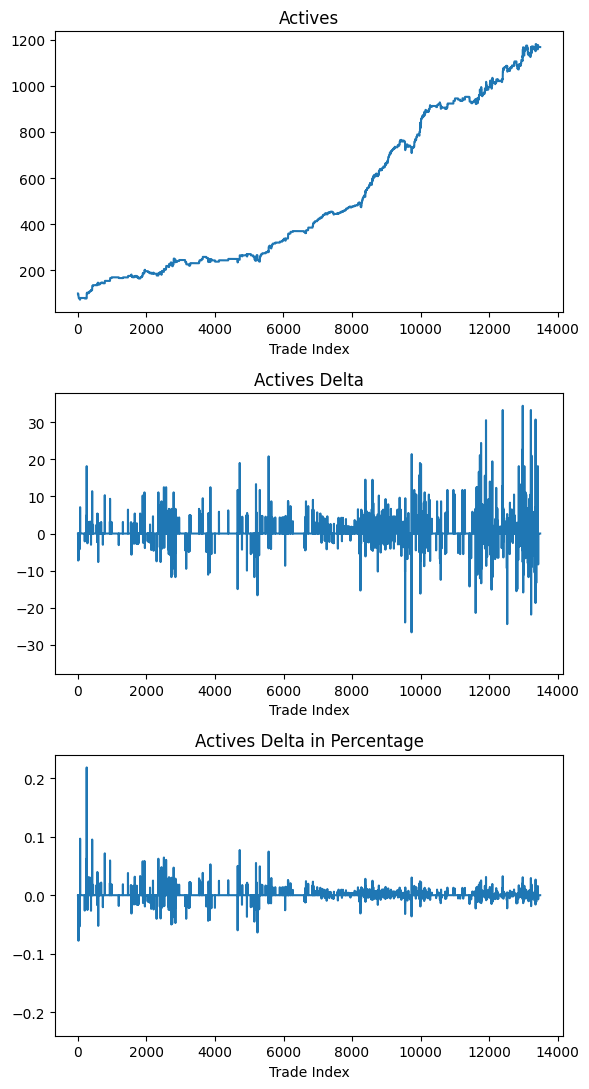

In [377]:
market_data = processed_markets[4]
binance_delta = binance_deltas[4]

print("Label:", market_data.label)
result = simulate_trading(
    market_data.close,
    binance_delta,
    starting_balance=100,
    min_delta=30,
    transaction_fee=0.0026,
)
plot_result(result)